[Social distancing detection tool](https://www.analyticsvidhya.com/blog/2020/05/social-distancing-detection-tool-deep-learning/)

Works only on [Google colab](https://colab.research.google.com/) because it requires GPUs

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

import pandas as pd
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 20)
pd.set_option('precision', 3)

## Install dependencies

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# opencv is pre-installed on colab

!pip install torchvision
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!gcc --version

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

In [4]:
import torch
print('torch version:', torch.__version__)
print('Is cuda available?', torch.cuda.is_available())

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import cv2
from google.colab.patches import cv2_imshow
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

torch version: 1.5.0+cu101
Is cuda available? False


In [0]:
!wget https://drive.google.com/u/0/uc\?id\=1N_nJRs7gStNrfB1G9y2yPs5voe4Ip4On\&export\=download -O sample.mp4
!rm -r frames/*
!mkdir -p frames/

In [9]:
%%time

def extract_frames(video_file, num_frames, output_folder) -> bool:
    cap = cv2.VideoCapture(video)

    if cap.isOpened() == False:
        return False

    frame_index = 0
    while cap.isOpened() and frame_index < num_frames:
        # read frame-by-frame
        ret, frame = cap.read()
        if ret:
            # save each frame
            cv2.imwrite(f'{output_folder}/{frame_index}.png', frame)
            frame_index += 1
        else:
            break

    print(f'Frame rate:', cap.get(cv2.CAP_PROP_FPS))

    return frame_index >= num_frames

video = 'sample.mp4'
num_frames = 300

print(f'Capturing {num_frames} frames')

res = extract_frames(video, num_frames, 'frames')
if res:
    print('Success')
else:
    print('Failed')

Capturing 300 frames
Frame rate: 25.0
Success
CPU times: user 27.2 s, sys: 1.17 s, total: 28.4 s
Wall time: 27.1 s


In [12]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not 
# running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))

# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")

predictor = DefaultPredictor(cfg)

model_final_f97cb7.pkl: 136MB [00:13, 9.74MB/s]                           


In [0]:
#read an image
img = cv2.imread("frames/30.png")

#pass to the model
outputs = predictor(img)

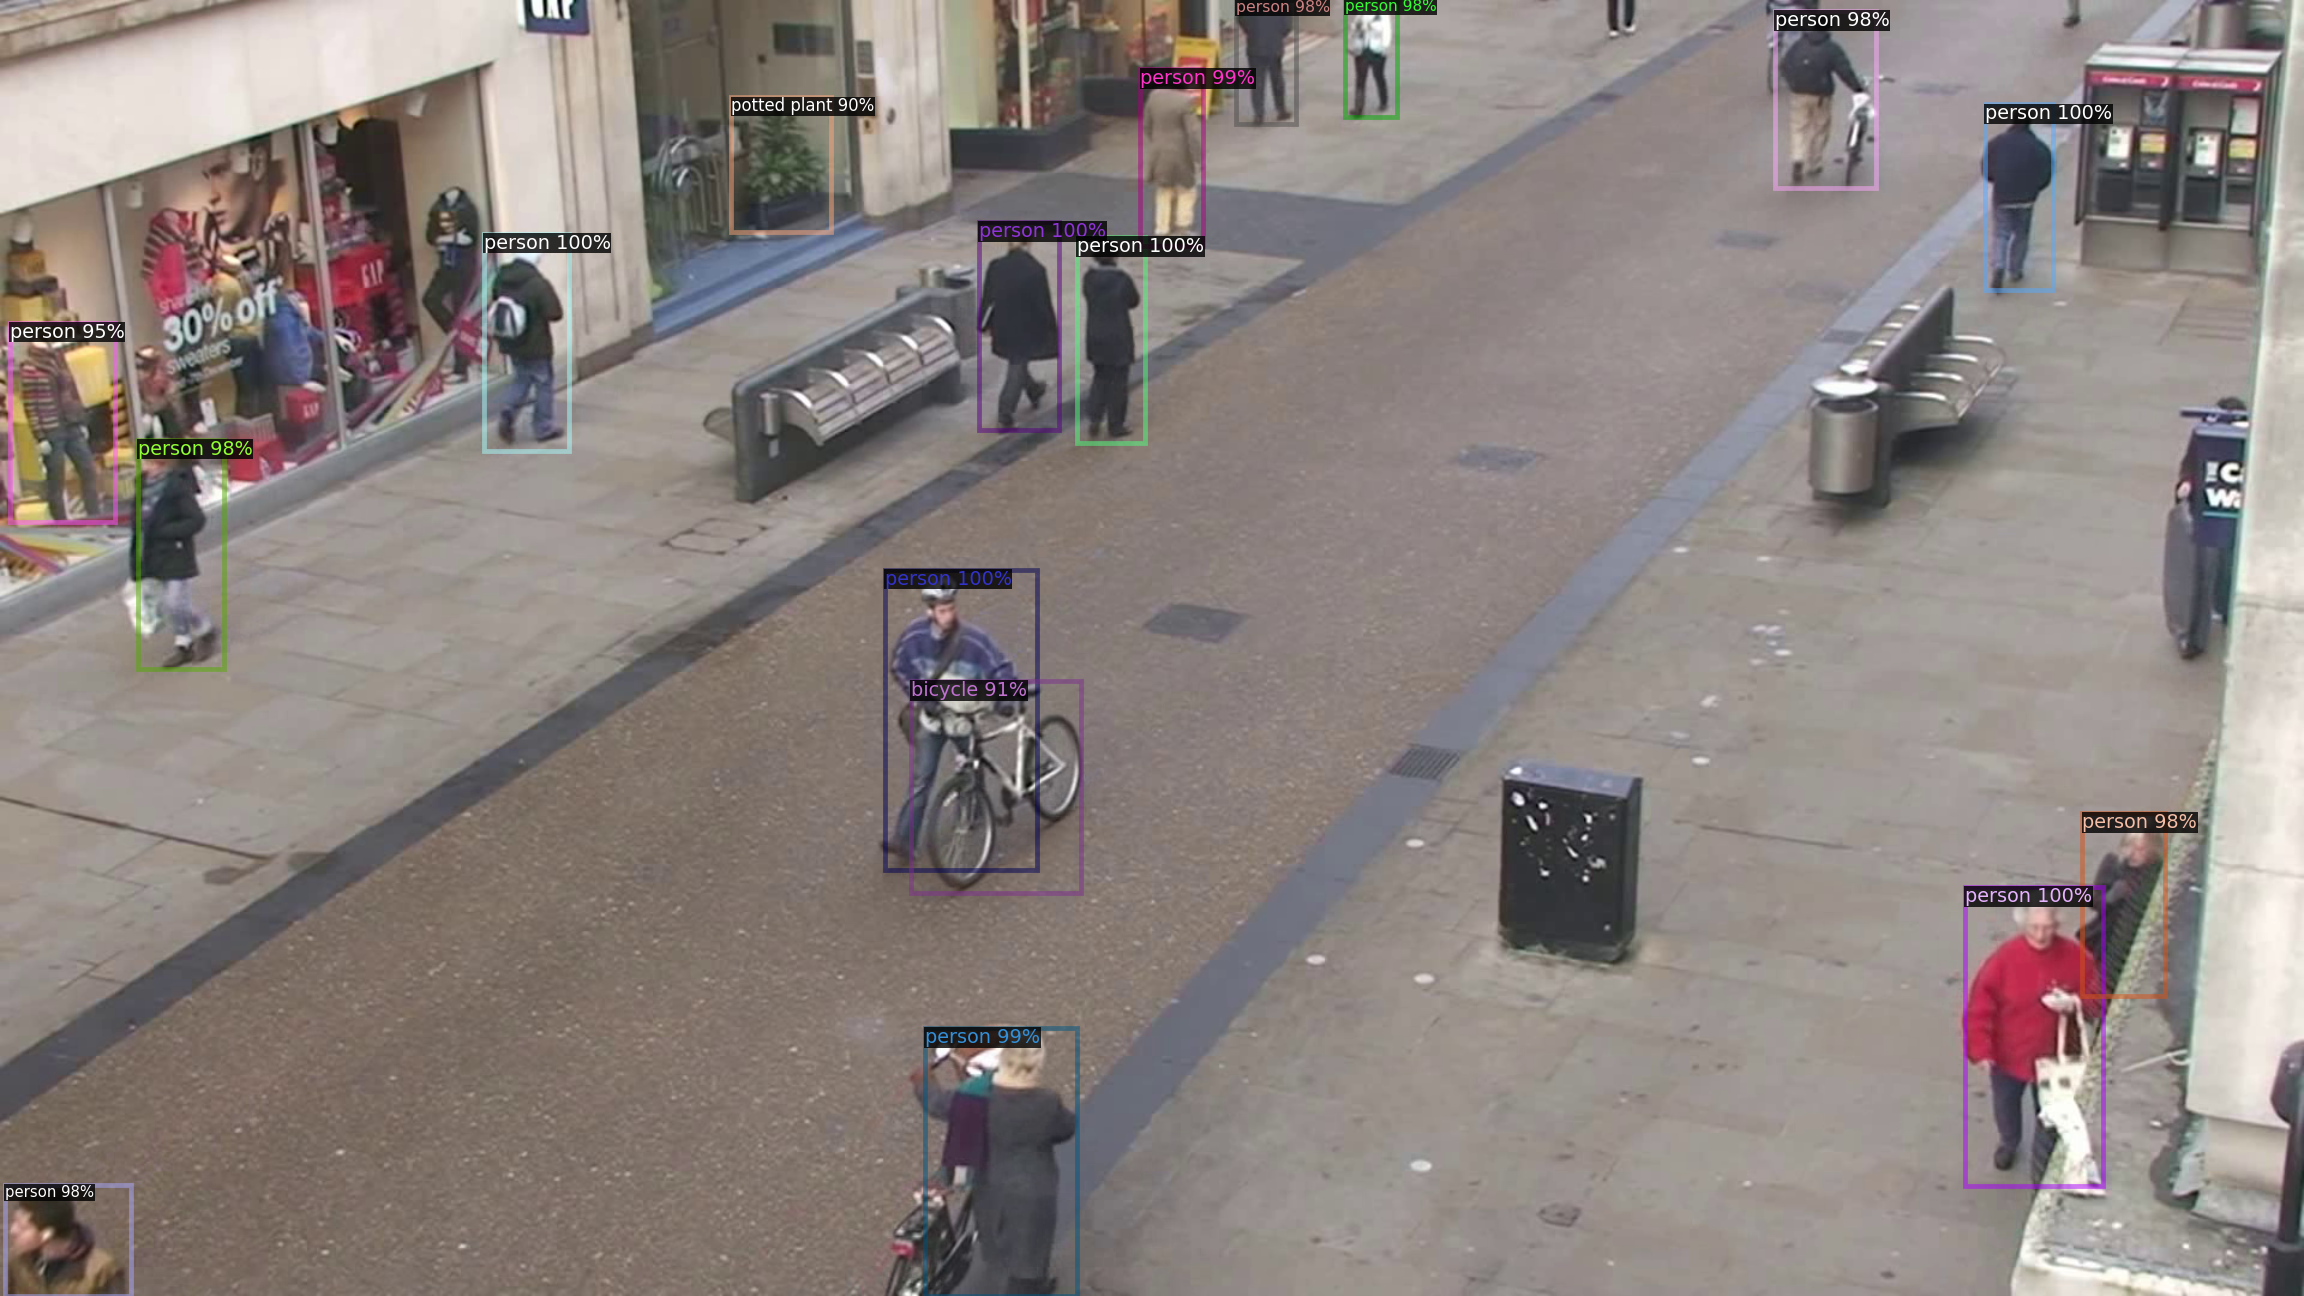

In [18]:
# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1],
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(v.get_image()[:, :, ::-1])

In [19]:
classes = outputs['instances'].pred_classes.cpu().numpy()
print(classes)

bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 58]
[[8.97625732e+02 1.98114746e+02 9.54295410e+02 3.69938965e+02]
 [8.15539734e+02 1.85776886e+02 8.82243225e+02 3.58775421e+02]
 [7.37155396e+02 4.75216461e+02 8.64526611e+02 7.25281311e+02]
 [1.63727197e+03 7.39270691e+02 1.75216077e+03 9.88613037e+02]
 [4.02958832e+02 1.95546768e+02 4.74301331e+02 3.76508423e+02]
 [1.65389941e+03 8.78322067e+01 1.71117517e+03 2.42416138e+02]
 [9.50240295e+02 5.83510170e+01 1.00226202e+03 2.05864594e+02]
 [7.70899719e+02 8.57066589e+02 8.97423706e+02 1.08000000e+03]
 [1.14824585e+02 3.66958710e+02 1.86961533e+02 5.57881042e+02]
 [3.88901734e+00 9.87568298e+02 1.09564423e+02 1.08000000e+03]
 [1.73523938e+03 6.77691223e+02 1.80430774e+03 8.29950134e+02]
 [1.12059473e+03 0.00000000e+00 1.16453687e+03 9.86647034e+01]
 [1.47889429e+03 1.01930170e+01 1.56364978e+03 1.57773285e+02]
 [1.02976807e+03 1.21371460e+00 1.07966443e+03 1.04322647e+02]
 [8.13121510e+00 2.69681549e+02 9.55819016e+01 4.35993988e+02]
 [

In [20]:
#identity only persons 
ind = np.where(classes == 0)[0]

#identify bounding box of only persons
person = bbox[ind]

#total no. of persons
num = len(person)

x1, y1, x2, y2 = person[0]
print(x1, y1, x2, y2)

897.62573 198.11475 954.2954 369.93896


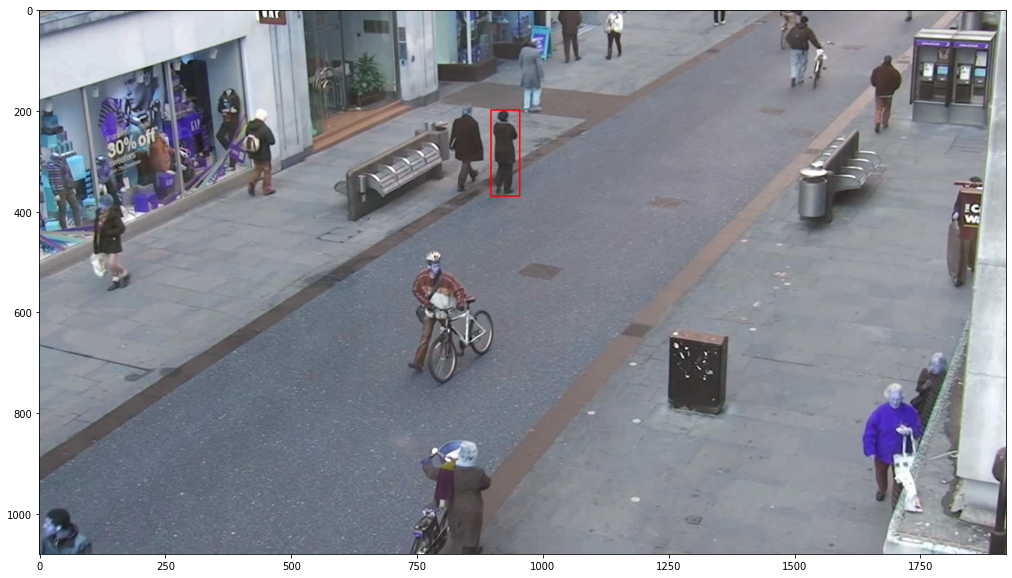

In [21]:
img = cv2.imread('frames/30.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

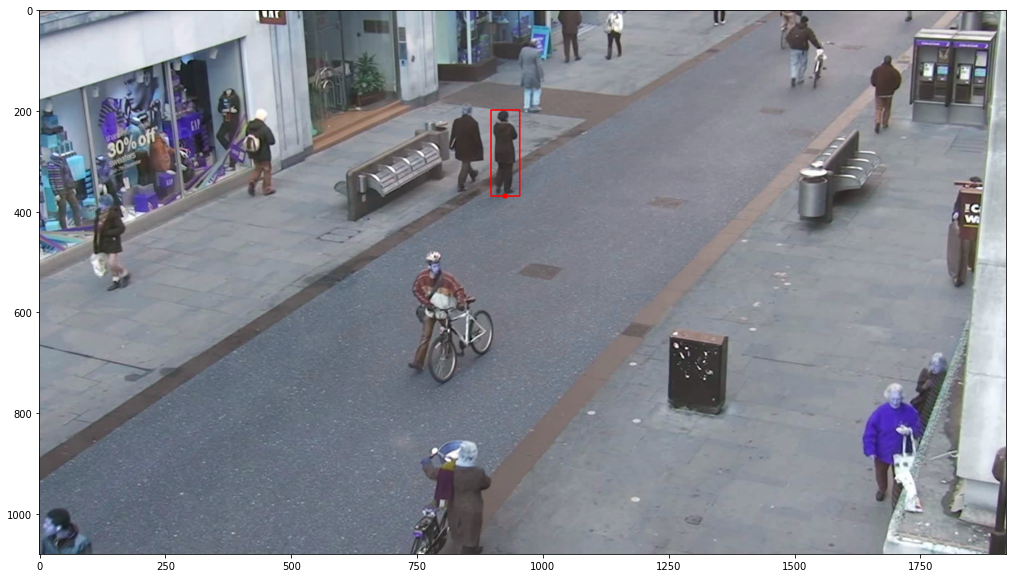

In [22]:
#compute center 
x_center = int((x1 + x2) / 2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20, 10))
plt.imshow(img)

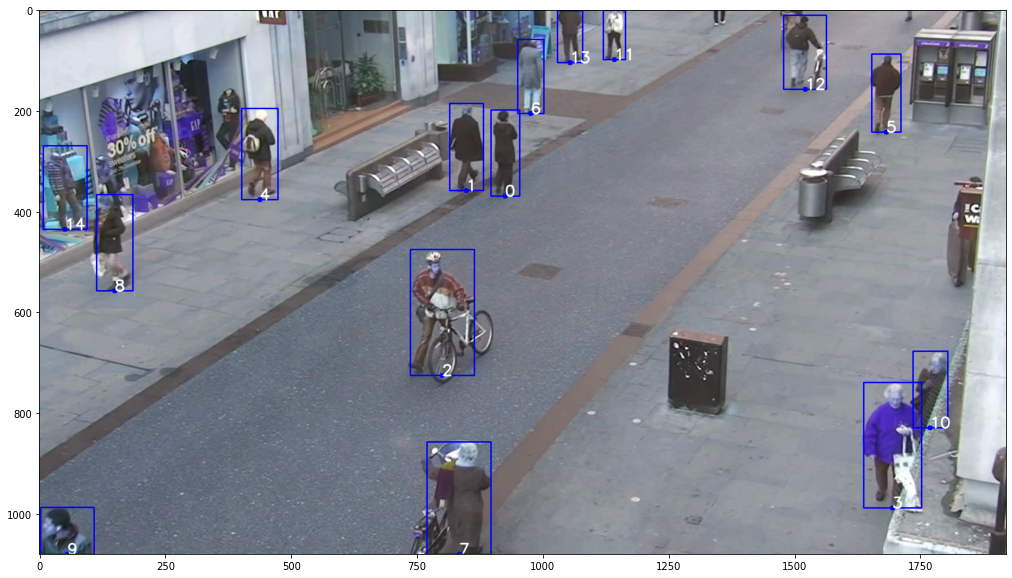

In [23]:
def mid_point(img, person, idx):
    """Function that returns the bottom center of every bbox"""

    # get the coordinates
    x1, y1, x2, y2 = person[idx]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # compute bottom center of bbox
    x_mid = int((x1 + x2)/2)
    y_mid = int(y2)
    mid = (x_mid, y_mid)

    _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
    cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,
                1, (255, 255, 255), 2, cv2.LINE_AA)

    return mid

midpoints = [mid_point(img, person, i) for i in range(len(person))]

# visualize image
plt.figure(figsize=(20, 10))
plt.imshow(img)

In [0]:
from scipy.spatial import distance

def compute_distance(midpoints, num):
    dist = np.zeros((num, num))
    
    for i in range(num):
        for j in range(i+1, num):
            if i != j:
                dst = distance.euclidean(midpoints[i], midpoints[j])
                dist[i][j] = dst
    return dist

def find_closest(dist, num, thresh):
    p1 = []
    p2 = []
    d = []
    for i in range(num):
        for j in range(i, num):
            if((i != j) & (dist[i][j] <= thresh)):
                p1.append(i)
                p2.append(j)
                d.append(dist[i][j])
                
    return p1, p2, d

In [26]:
thresh = 100

dist = compute_distance(midpoints, num)

p1, p2, d = find_closest(dist, num, thresh)
df = pd.DataFrame({"p1": p1, "p2": p2, "dist": d})
df

p1  p2    dist
0   0   1  77.782
1  11  13  88.204

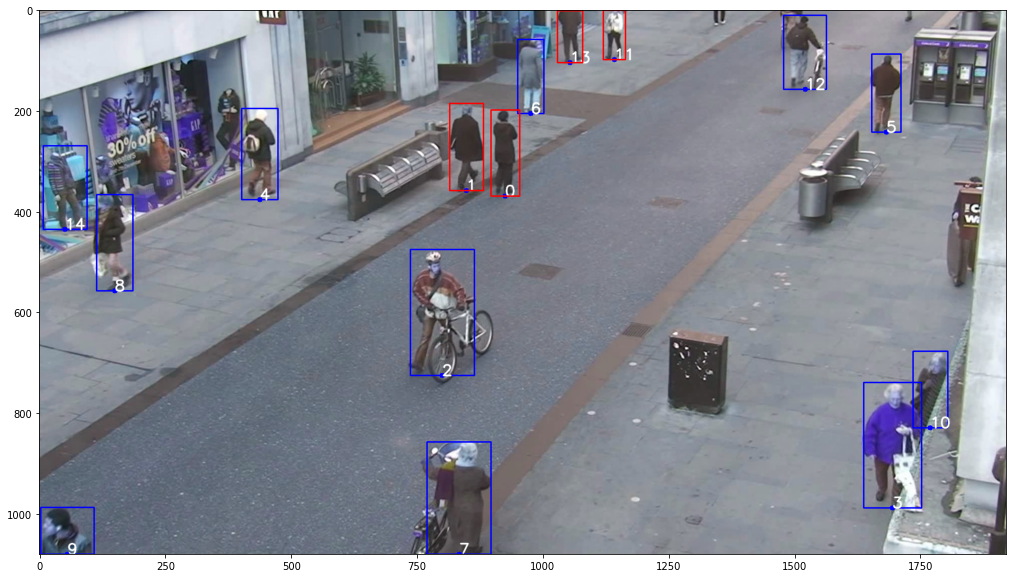

In [27]:
def change_2_red(img, person, p1, p2):
    risky = np.unique(p1+p2)
    for i in risky:
        x1, y1, x2, y2 = person[i]
        _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return img


img = change_2_red(img, person, p1, p2)

plt.figure(figsize=(20, 10))
plt.imshow(img)

In [0]:
import os
import re

names = os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [0]:
def find_closest_people(name, thresh):
    img = cv2.imread(f'frames/{name}')
    outputs = predictor(img)
    classes = outputs['instances'].pred_classes.cpu().numpy()
    bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
    ind = np.where(classes == 0)[0]
    person = bbox[ind]
    midpoints = [mid_point(img, person, i) for i in range(len(person))]
    num = len(midpoints)
    
    dist = compute_distance(midpoints, num)
    p1, p2, d = find_closest(dist, num, thresh)
    
    img = change_2_red(img, person, p1, p2)
    cv2.imwrite(f'frames/{name}', img)
    
    return 0

In [30]:
from tqdm import tqdm

thresh = 100
_ = [find_closest_people(names[i], thresh) for i in tqdm(range(len(names)))]

100%|██████████| 750/750 [05:06<00:00,  2.45it/s]


In [31]:
%%time

frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array = []

for i in range(len(frames)):

    # reading each files
    img = cv2.imread(f'frames/{frames[i]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width, height)

    # inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 25, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 48.3 s, sys: 3.47 s, total: 51.8 s
Wall time: 50.7 s
